In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cpi
from matplotlib.lines import Line2D

In [40]:
cpi.update()

In [62]:
data = pd.read_csv('datafiles/dispositions_and_opex_and_transmission_and_sales.csv')

In [63]:
data.columns

Index(['Unnamed: 0', 'disposition_of_energy', 'energy_losses',
       'internal_use_energy',
       'megawatt_hours_sold_sales_to_ultimate_consumers', 'utility_id_ferc1',
       'report_year', 'load_dispatching',
       'administrative_and_general_expenses',
       'administrative_and_general_operation_expense',
       'administrative_and_general_salaries', 'distribution_expenses',
       'distribution_maintenance_expense_electric',
       'distribution_operation_expenses_electric', 'transmission_expenses',
       'transmission_maintenance_expense_electric',
       'transmission_operation_expense', 'underground_line_expenses',
       'overhead_line_expenses', 'overhead_line_expense',
       'transmission_line_length_miles',
       'transmission_line_and_structures_length_miles',
       'num_transmission_circuits', 'capex_land', 'capex_other', 'capex_total',
       'opex_operations', 'opex_maintenance', 'opex_rents', 'opex_total',
       'avg_customers_per_month', 'sales_mwh'],
      dt

# Data Cleaning

* Dropping 1994 and 2021 data - looks wrong
* Dropping extra index column

In [64]:
data = data[data.report_year != 2021]
data = data[data.report_year != 1994]
data.drop(labels='Unnamed: 0',axis='columns',inplace=True)

* Reading in the fuzzy-merged + handcorrected EIA/FERC crosswalk
* Reading back in the EIA plant IDs and merging
* Merging EIA plants with NERC regions, then merging back with FERC crosswalk

In [143]:
eia_ferc = pd.read_csv('datafiles/eia ferc fuzzy matched manually corrected.csv').dropna(subset='eia')

eia_codes = pd.read_csv('datafiles/utilities_entity_eia.csv')


merged_eia_codes = pd.merge(eia_ferc,
        eia_codes,
        left_on='eia',
        right_on='utility_name_eia',
        how='left')

ferc_codes = pd.read_csv('datafiles/utilities_ferc1.csv')


merged_ferc_codes = pd.merge(merged_eia_codes,
                            ferc_codes,
                            left_on='ferc',
                            right_on='utility_name_ferc1',
                            how='right')[['utility_id_eia',
                                         'utility_id_ferc1',
                                         'utility_name_ferc1',
                                         'utility_name_eia']]

In [150]:
states = pd.read_csv('datafiles/utilities_eia860.csv',usecols=[0,2,5])
states['year_dt'] = pd.to_datetime(states['report_date']).dt.year

In [170]:
nerc = pd.read_excel('datafiles/StateCodesNERC.xlsx')
merged_eia_interconn_regions = pd.merge(nerc,states,how='right',left_on='Code',right_on='state')[['NERC','State','Code','utility_id_eia']]

In [176]:
ferc_subset_with_nercregion = pd.merge(merged_eia_interconn_regions,
        merged_ferc_codes,
        how='right',
        on='utility_id_eia').dropna(subset='NERC').drop_duplicates()

# Analysis

Producing aggregate annual numbers for key variables

In [73]:
capex_total = data.groupby('report_year')['capex_total'].agg('sum').reset_index(drop=False)
opex_total = data.groupby('report_year')['opex_total'].agg('sum').reset_index(drop=False)
megawatt_hours_sold_sales_to_ultimate_consumers = data.groupby('report_year')['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
transmission_line_length_miles = data.groupby('report_year')['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
transmission_expenses = data.groupby('report_year')['transmission_expenses'].agg('sum').reset_index(drop=False)
distribution_expenses = data.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
customer_total = data.groupby('report_year')['avg_customers_per_month'].agg('sum').reset_index(drop=False)

Inflation adjusting T&D costs and generating normalized variables

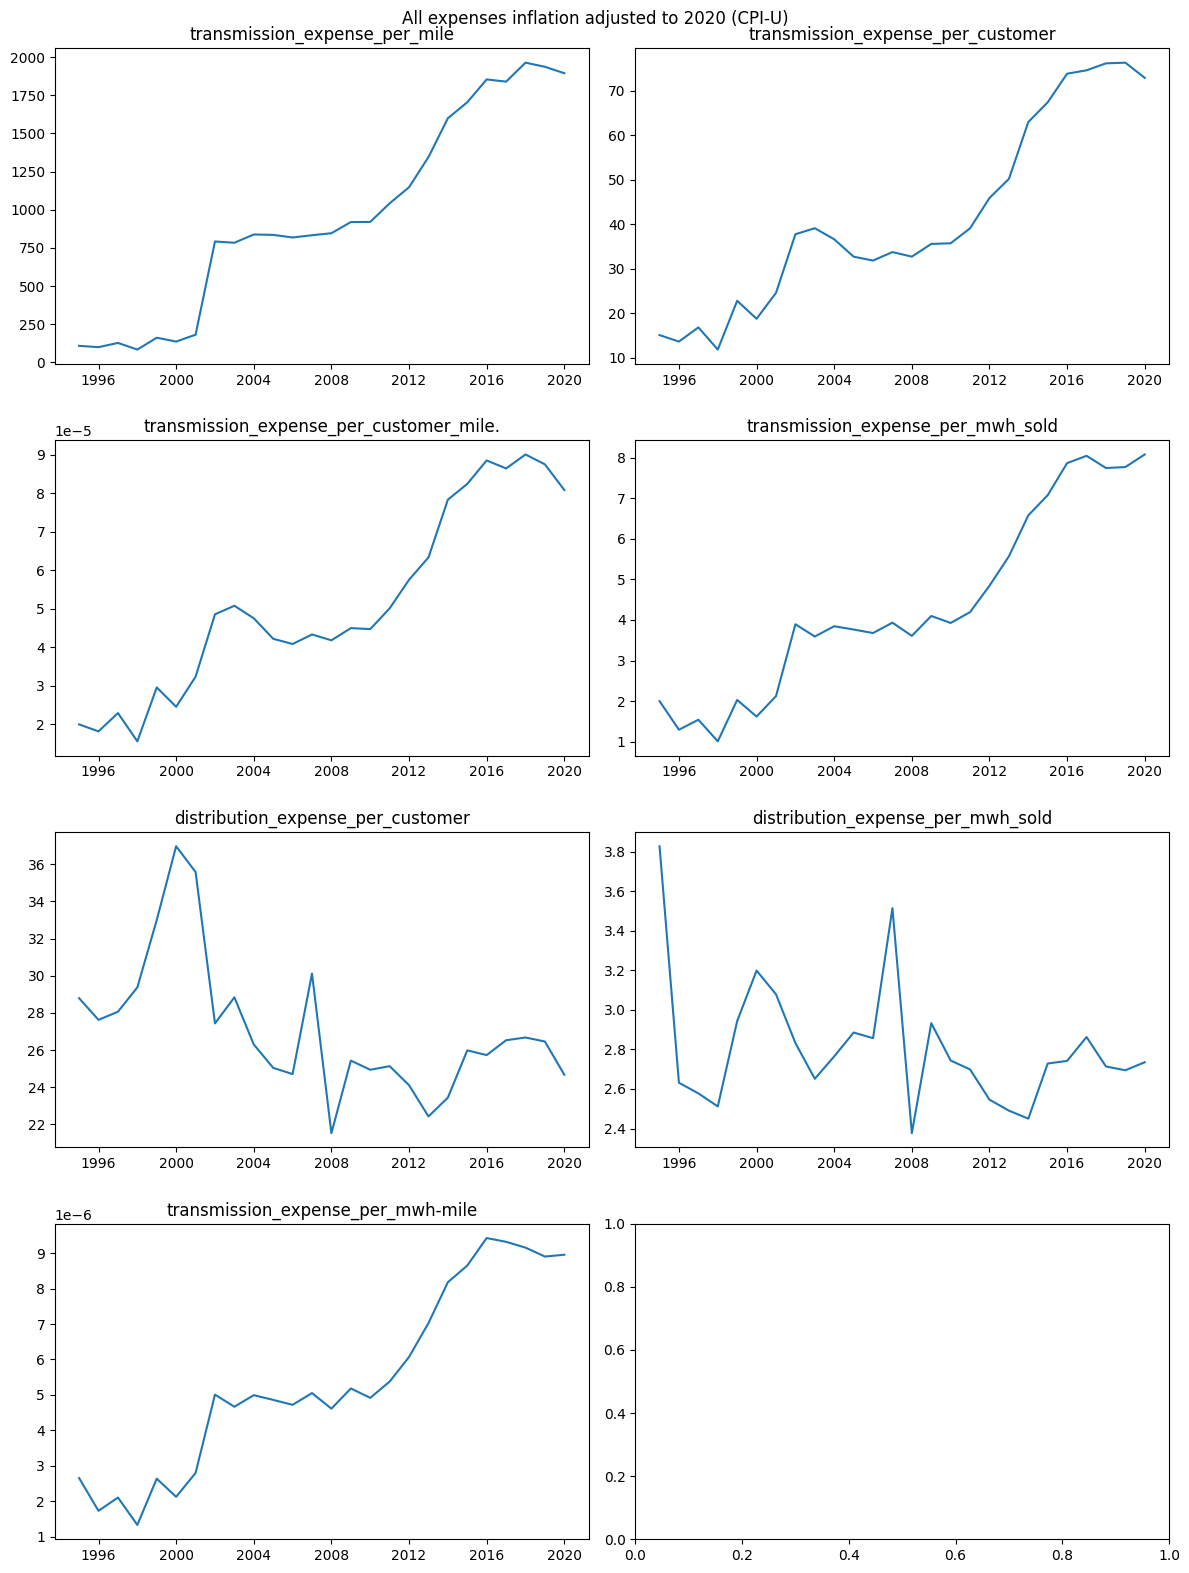

In [213]:
transmission_expenses['year_dt']=pd.to_datetime(transmission_expenses.report_year, format='%Y')
real_transmission_expenses = transmission_expenses.apply(lambda x: cpi.inflate(x["transmission_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
transmission_expenses['inflation-adjusted expenses']= real_transmission_expenses

transmission_expense_per_mile = transmission_expenses['inflation-adjusted expenses']/transmission_line_length_miles['transmission_line_length_miles']
transmission_expense_per_customer = transmission_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
transmission_expense_per_customer_mile = transmission_expenses['inflation-adjusted expenses']/(customer_total['avg_customers_per_month']*transmission_line_length_miles['transmission_line_length_miles'])
transmission_expense_per_mwh_sold = transmission_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']
transmission_expense_per_mwh_mile = transmission_expenses['inflation-adjusted expenses']/(megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']*transmission_line_length_miles['transmission_line_length_miles'])


distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
distribution_expenses['inflation-adjusted expenses']= real_distribution_expenses

distribution_expense_per_customer = distribution_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
distribution_expense_per_mwh_sold = distribution_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']





fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(12,16))
plt.suptitle("All expenses inflation adjusted to 2020 (CPI-U)")
axs[0, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mile)
axs[0, 0].set_title("transmission_expense_per_mile")
axs[0, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_customer)
axs[0, 1].set_title("transmission_expense_per_customer")
axs[1, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_customer_mile)
axs[1, 0].set_title("transmission_expense_per_customer_mile.")
axs[1, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_sold)
axs[1, 1].set_title("transmission_expense_per_mwh_sold")
axs[2, 0].plot(transmission_expenses['year_dt'],distribution_expense_per_customer)
axs[2, 0].set_title("distribution_expense_per_customer")
axs[2, 1].plot(transmission_expenses['year_dt'],distribution_expense_per_mwh_sold)
axs[2, 1].set_title("distribution_expense_per_mwh_sold")

axs[3, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_mile)
axs[3, 0].set_title("transmission_expense_per_mwh-mile")

fig.tight_layout()
plt.show()
fig.savefig('graphs/inflation adjusted & normalized T&D costs over time.png',bbox_inches='tight',dpi=600)



## Repeating analysis for NERC subregion subset

In [181]:
nerc_interconn_subset_data_disagg = pd.merge(ferc_subset_with_nercregion,
        data,
        how='inner',
        left_on=['utility_id_ferc1'],
        right_on=['utility_id_ferc1'])

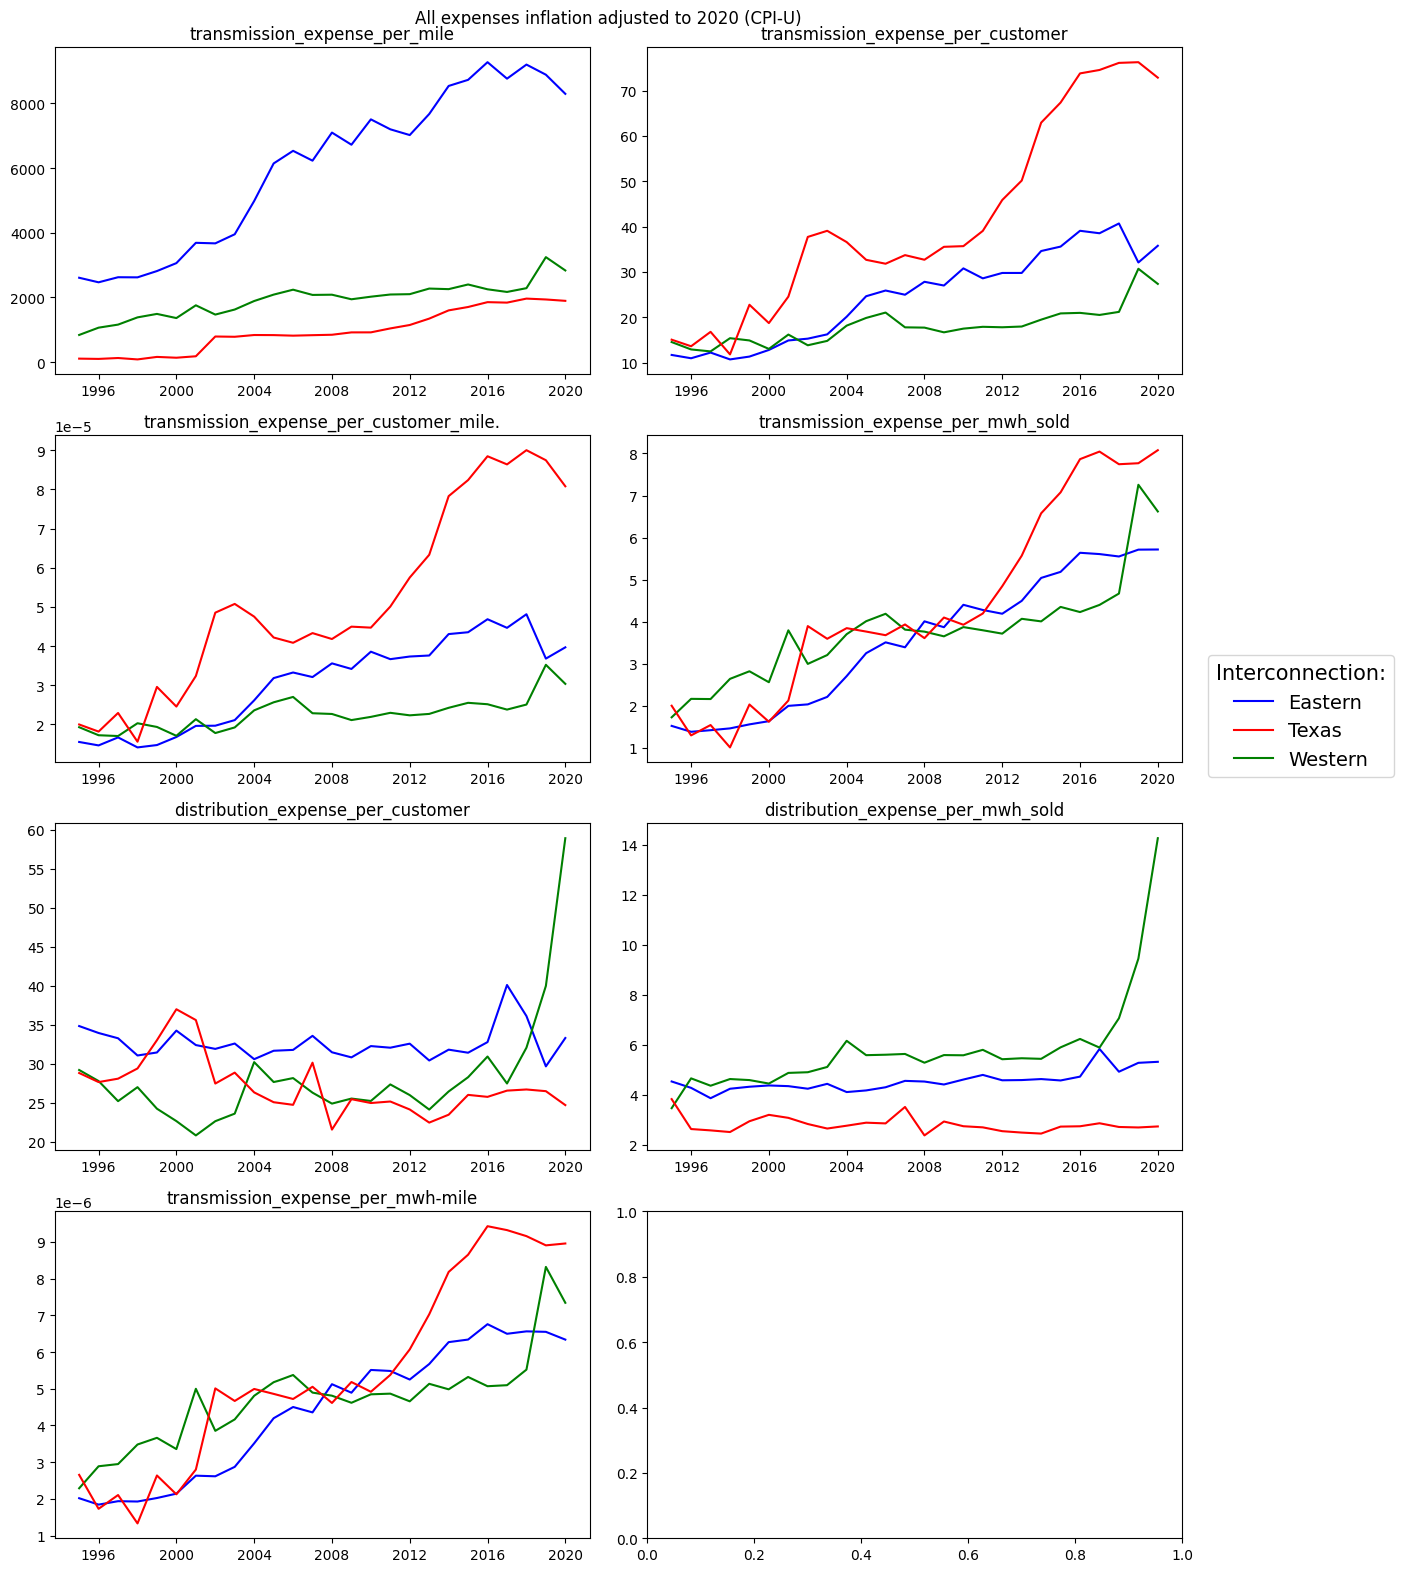

In [216]:
capex_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['capex_total'].agg('sum').reset_index(drop=False)
opex_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['opex_total'].agg('sum').reset_index(drop=False)
megawatt_hours_sold_sales_to_ultimate_consumers = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
transmission_line_length_miles = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
transmission_expenses = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['transmission_expenses'].agg('sum').reset_index(drop=False)
distribution_expenses = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['distribution_expenses'].agg('sum').reset_index(drop=False)
customer_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['avg_customers_per_month'].agg('sum').reset_index(drop=False)


fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(12,16))
plt.suptitle("All expenses inflation adjusted to 2020 (CPI-U)")

axs[0, 0].set_title("transmission_expense_per_mile")
axs[0, 1].set_title("transmission_expense_per_customer")
axs[1, 0].set_title("transmission_expense_per_customer_mile.")
axs[1, 1].set_title("transmission_expense_per_mwh_sold")
axs[2, 0].set_title("distribution_expense_per_customer")
axs[2, 1].set_title("distribution_expense_per_mwh_sold")

fig.tight_layout()


for nerc_reg,color in {'Eastern':'blue','Western':'green','Texas':'red'}.items():
    
    data_subset = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['NERC']==nerc_reg]
    
    capex_total = data_subset.groupby('report_year')['capex_total'].agg('sum').reset_index(drop=False)
    opex_total = data_subset.groupby('report_year')['opex_total'].agg('sum').reset_index(drop=False)
    megawatt_hours_sold_sales_to_ultimate_consumers = data_subset.groupby('report_year')['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
    transmission_line_length_miles = data.groupby('report_year')['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
    transmission_expenses = data_subset.groupby('report_year')['transmission_expenses'].agg('sum').reset_index(drop=False)
    distribution_expenses = data_subset.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
    customer_total = data_subset.groupby('report_year')['avg_customers_per_month'].agg('sum').reset_index(drop=False)
    

    transmission_expenses['year_dt']=pd.to_datetime(transmission_expenses.report_year, format='%Y')
    real_transmission_expenses = transmission_expenses.apply(lambda x: cpi.inflate(x["transmission_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                                                   axis=1)
    transmission_expenses['inflation-adjusted expenses']= real_transmission_expenses

    transmission_expense_per_mile = transmission_expenses['inflation-adjusted expenses']/transmission_line_length_miles['transmission_line_length_miles']
    transmission_expense_per_customer = transmission_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
    transmission_expense_per_customer_mile = transmission_expenses['inflation-adjusted expenses']/(customer_total['avg_customers_per_month']*transmission_line_length_miles['transmission_line_length_miles'])
    transmission_expense_per_mwh_sold = transmission_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']
    transmission_expense_per_mwh_mile = transmission_expenses['inflation-adjusted expenses']/(megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']*transmission_line_length_miles['transmission_line_length_miles'])





    distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
    real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                                                   axis=1)
    distribution_expenses['inflation-adjusted expenses']= real_distribution_expenses

    distribution_expense_per_customer = distribution_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
    distribution_expense_per_mwh_sold = distribution_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']

    axs[0, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mile,label=nerc_reg,color=color)
    axs[0, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_customer,label=nerc_reg,color=color)
    axs[1, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_customer_mile,label=nerc_reg,color=color)
    axs[1, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_sold,label=nerc_reg,color=color)
    axs[2, 0].plot(transmission_expenses['year_dt'],distribution_expense_per_customer,label=nerc_reg,color=color)
    axs[2, 1].plot(transmission_expenses['year_dt'],distribution_expense_per_mwh_sold,label=nerc_reg,color=color)
    axs[3, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_mile,label=nerc_reg,color=color)
    axs[3, 0].set_title("transmission_expense_per_mwh-mile")



custom_lines = [Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='red'),
                Line2D([0], [0], color='green')
               ]
fig.legend(custom_lines, ['Eastern', 'Texas', 'Western'], 
           loc=(0,0),
           bbox_to_anchor=(1,0.5),
           fontsize=14,
          title='Interconnection:',
           title_fontsize=15
          )
plt.show()

fig.savefig('graphs/inflation adjusted & normalized T&D costs over time - nerc subset.png',bbox_inches='tight',dpi=600)


